In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
def prot_div(left, right):
    if right == 0:
        return 0
    else:
        return left / right

def if_func(condition, state1, state2):
    if condition:
        return state1
    else:
        return state2

def read_experiment_results(full_path, iterations, epochs=100):
    dir_name = full_path
    results = []
    for it in range(iterations):
        with open(dir_name + 'iteration_' + str(it) + '.json') as json_file:
            if it % 10 == 0:
                print(it)
            data = json.load(json_file)
            results.append(data)
    print("Finished reading ", full_path)
    return results


In [8]:
results = []
month = '1'
day = '17'
trial_number = '2'
#folder_name = 'dumps_' + month + '_' + day
folder_name = 'dumps/adaptiveTest'
#folder_name = 'trial' + trial_number
#run_number = ['2','3','4','5','6','7','8','9','11','12']
run_number = ['1','2','3','4','5','6','7','8','9','10']
iterations = 1500
for i in run_number: 
    results.append(read_experiment_results(folder_name + '/run_' + i + '/', iterations))


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
Finished reading  /Users/soren/Library/Mobile Documents/iCloud~md~obsidian/Documents/obsidian/results/autolr-2022-05-10/run_4/


------NEW BEST------
0--0.12160605937242508
tf.math.multiply(alpha, tf.math.multiply(tf.math.divide_no_nan(tf.constant(1.56514861e-02, shape=shape, dtype=tf.float32), tf.math.square(grad)), grad))
--------------------
------NEW BEST------
2--0.7726272642612457
tf.math.multiply(alpha, tf.math.multiply(tf.math.pow(tf.math.divide_no_nan(tf.math.square(grad), tf.constant(1.56514861e-02, shape=shape, dtype=tf.float32)), grad), grad))
--------------------
------NEW BEST------
11--0.8073363602161407
tf.math.multiply(alpha, tf.math.add(grad, grad))
--------------------
------NEW BEST------
16--0.8217727343241373
tf.math.multiply(alpha, tf.math.add(grad, grad))
--------------------
------NEW BEST------
17--0.8249606092770895
tf.math.multiply(alpha, tf.math.add(grad, grad))
--------------------
------NEW BEST------
93--0.8267272810141245
tf.math.multiply(alpha, tf.math.add(grad, grad))
--------------------
------NEW BEST------
458--0.8278363645076752
tf.math.add(tf.math.negative(tf.math.sqrt(alp

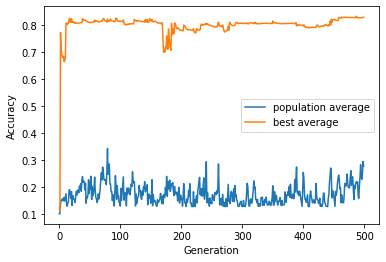

In [46]:
def abridged_phenotype(phenotype):
    functions = phenotype.split(r'lambda shape,  alpha')
    alpha_func_string = functions[1][8:-2]
    beta_func_string =functions[2][14:-2] 
    sigma_func_string =functions[3][21:-2] 
    grad_func_string = functions[-1][21:].replace('alpha', alpha_func_string).replace('beta', beta_func_string).replace('sigma', sigma_func_string)
    return grad_func_string

def plot_fit(results):
    epochs = np.arange(len(results[0]))
    #print(epochs)
    averages_all = []
    bests_all = []
    stds_all = []
    best_of_all = []
    stds_best_all = [] 
    boa_fit = 0
    boa_indiv = None
    for iteration in epochs:
        averages_all.append([])
        bests_all.append([])
        stds_all.append([])
        best_of_all.append(0)
        stds_best_all.append(0)        
        for result in results:
            all_fits = []
            best = 0
            gen_best = 0
            for indiv in result[iteration]:
                if indiv['fitness'] < best:
                    best = indiv['fitness']
                    #plot_iter([indiv])
                    #print(indiv['other_info'].keys())
                    if indiv['fitness'] < boa_fit:
                        boa_fit = best
                        boa_indiv = indiv
                        print(f'------NEW BEST------\n{iteration}-{boa_fit}\n{abridged_phenotype(indiv["phenotype"])}\n--------------------')
                        #plot_iter([boa_indiv], len(indiv['other_info']['loss']), color='red', id_num=iteration)
                best = best if indiv['fitness'] > best else indiv['fitness']
                all_fits.append(indiv['fitness'])
            averages_all[iteration].append(np.average(all_fits))
            stds_all[iteration].append(np.std(all_fits))
            bests_all[iteration].append(best)
        stds_best_all[iteration] = np.std(bests_all[iteration]) * -1
        stds_all[iteration] = np.std(averages_all[iteration])
        averages_all[iteration] = np.average(averages_all[iteration]) * -1
        best_of_all[iteration] = np.min(bests_all[iteration])  * -1
        bests_all[iteration] = np.average(bests_all[iteration]) * -1
    plt.plot(epochs, averages_all, label='population average')
    plt.fill_between(epochs, [i + j for i, j in zip(averages_all, stds_all)], [i - j for i, j in zip(averages_all, stds_all)], alpha=0.2)
    plt.plot(epochs, bests_all, label='best average')   
    plt.fill_between(epochs, [i + j for i, j in zip(bests_all, stds_best_all)], [i - j for i, j in zip(bests_all, stds_best_all)], alpha=0.2)
    #plt.plot(epochs, [0.7862666646639506 for i in bests_all], label='fixed lr val_acc')
    #plt.plot(epochs, best_of_all, label='best of all')
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('best_average_evolution.pdf')
    plt.show()

plot_fit(results)